# Change Point


Chuẩn bị dữ liệu

In [3]:
# --- CELL 1: CẤU HÌNH PATH ---
import sys
import os

# 1. Lấy đường dẫn thư mục hiện tại (Notebook/)
current_dir = os.getcwd()

# 2. Lấy đường dẫn thư mục cha (Root Project) để import được 'Module'
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# 3. Thêm Root vào sys.path để Python tìm thấy 'Module'
if project_root not in sys.path:
    sys.path.append(project_root)

# 4. Thêm Current Dir vào sys.path (thường mặc định có rồi, nhưng thêm cho chắc) để import được 'ChangePoint.py'
if current_dir not in sys.path:
    sys.path.append(current_dir)

print(f"Project Root: {project_root}")
print(f"Current Dir:  {current_dir}")

Project Root: c:\Users\ACER\PythonProject\PythonProject
Current Dir:  c:\Users\ACER\PythonProject\PythonProject\Notebook


In [4]:
# --- CELL 2: IMPORT VÀ CHẠY ---
import pandas as pd

from Module.Load_Data import CleanDataLoader
from ChangePoint import ChangePointPreparer

# Khởi tạo loader & preparer
clean_loader = CleanDataLoader(project_root=project_root)
preparer = ChangePointPreparer(clean_loader)

# Kiểm tra dữ liệu Toán
print("Đang lấy dữ liệu môn Toán...")

df_math = preparer.get_subject_series(
    subjects=["Toan"],   # PHẢI khớp tên thư mục CleanData_*
    metric="mean"
)

print(df_math)


Đang lấy dữ liệu môn Toán...
   year series_id     value
0  2023      Toan  6.250557
1  2024      Toan  6.447309
2  2025      Toan  4.799712


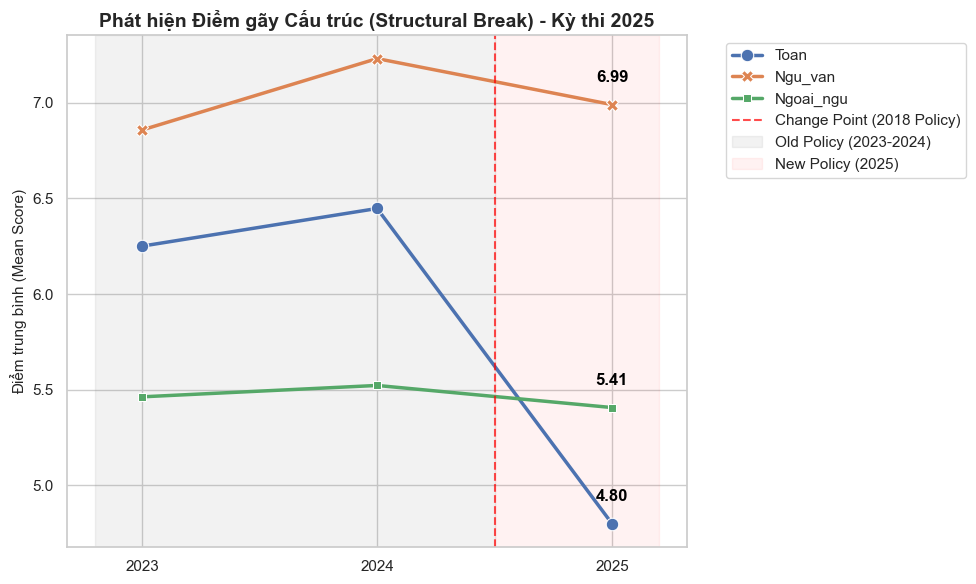

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử df_multi là dataframe bạn đã có
# df_multi = ... (lấy từ code của bạn)

# Setup style cho chuyên nghiệp
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# 1. Vẽ Line Chart
sns.lineplot(
    data=df_multi, 
    x="year", 
    y="value", 
    hue="series_id", 
    style="series_id", 
    markers=True, 
    dashes=False, 
    linewidth=2.5,
    markersize=9
)

# 2. TẠO ĐIỂM NHẤN: Vùng "Change Point"
# Vẽ đường đứt đoạn ngăn cách năm 2024 và 2025
plt.axvline(x=2024.5, color='red', linestyle='--', alpha=0.7, label='Change Point (2018 Policy)')

# Tô màu nền phân biệt 2 giai đoạn
plt.axvspan(2022.8, 2024.5, color='gray', alpha=0.1, label='Old Policy (2023-2024)')
plt.axvspan(2024.5, 2025.2, color='red', alpha=0.05, label='New Policy (2025)')

# 3. Annotate (Ghi chú trực tiếp giá trị lên điểm để sếp khỏi phải soi)
for sid in df_multi['series_id'].unique():
    subset = df_multi[df_multi['series_id'] == sid]
    # Chỉ ghi chú giá trị năm 2025 để nhấn mạnh
    val_2025 = subset[subset['year'] == 2025]['value'].values[0]
    plt.text(2025, val_2025 + 0.1, f'{val_2025:.2f}', 
             ha='center', va='bottom', fontweight='bold', color='black')

# 4. Trang trí
plt.title("Phát hiện Điểm gãy Cấu trúc (Structural Break) - Kỳ thi 2025", fontsize=14, fontweight='bold')
plt.ylabel("Điểm trung bình (Mean Score)", fontsize=11)
plt.xlabel(None)
plt.xticks([2023, 2024, 2025]) # Chỉ hiện đúng 3 năm này
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Đưa chú thích ra ngoài cho thoáng
plt.tight_layout()

plt.show()

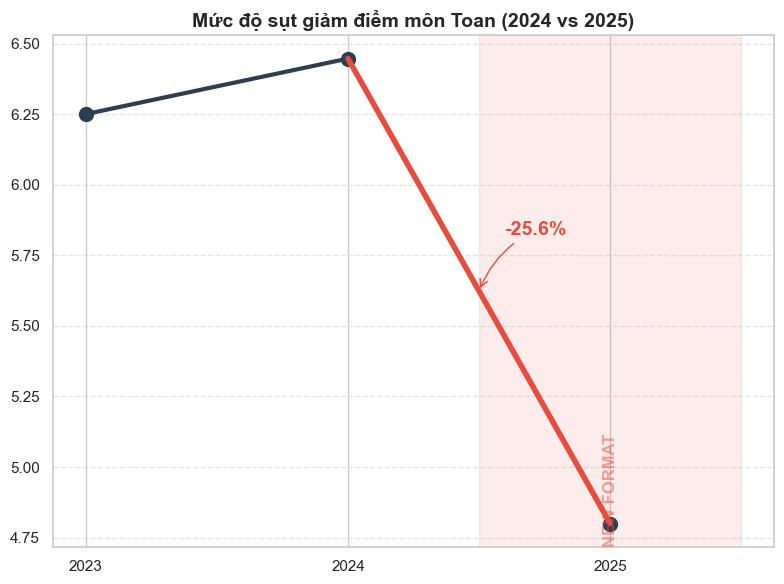

In [14]:
import matplotlib.pyplot as plt

# Lọc lấy môn Toán để demo (hoặc môn nào giảm mạnh nhất)
target_subject = "Toan" 
df_one = df_multi[df_multi['series_id'] == target_subject].sort_values("year")

val_2024 = df_one[df_one['year'] == 2024]['value'].values[0]
val_2025 = df_one[df_one['year'] == 2025]['value'].values[0]
change_pct = ((val_2025 - val_2024) / val_2024) * 100

plt.figure(figsize=(8, 6))

# Vẽ đường nối
plt.plot(df_one['year'], df_one['value'], marker='o', color='#2c3e50', linewidth=3, markersize=10)

# Tô màu đỏ đoạn "Gãy" (2024-2025)
plt.plot([2024, 2025], [val_2024, val_2025], color='#e74c3c', linewidth=4) 

# Thêm mũi tên hoặc text % thay đổi
mid_x = 2024.5
mid_y = (val_2024 + val_2025) / 2
plt.annotate(
    f'{change_pct:.1f}%', 
    xy=(mid_x, mid_y), 
    xytext=(mid_x + 0.1, mid_y + 0.2),
    color='#e74c3c',
    fontsize=14,
    fontweight='bold',
    arrowprops=dict(arrowstyle='->', color='#e74c3c', connectionstyle="arc3,rad=.2")
)

plt.title(f"Mức độ sụt giảm điểm môn {target_subject} (2024 vs 2025)", fontsize=14, fontweight='bold')
plt.xticks([2023, 2024, 2025])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Highlight vùng background năm 2025
plt.axvspan(2024.5, 2025.5, color='#e74c3c', alpha=0.1)
plt.text(2025, plt.ylim()[0], "NEW FORMAT", color='#e74c3c', alpha=0.5, fontweight='bold', ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.show()